Número de canais: 19
Frequência de amostragem: 977 Hz
Duração: 8729.20 segundos
Formatos dos sinais: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'ABL12', 'RVA12', 'CS12', 'CS34', 'CS56', 'CS78', 'CS90']


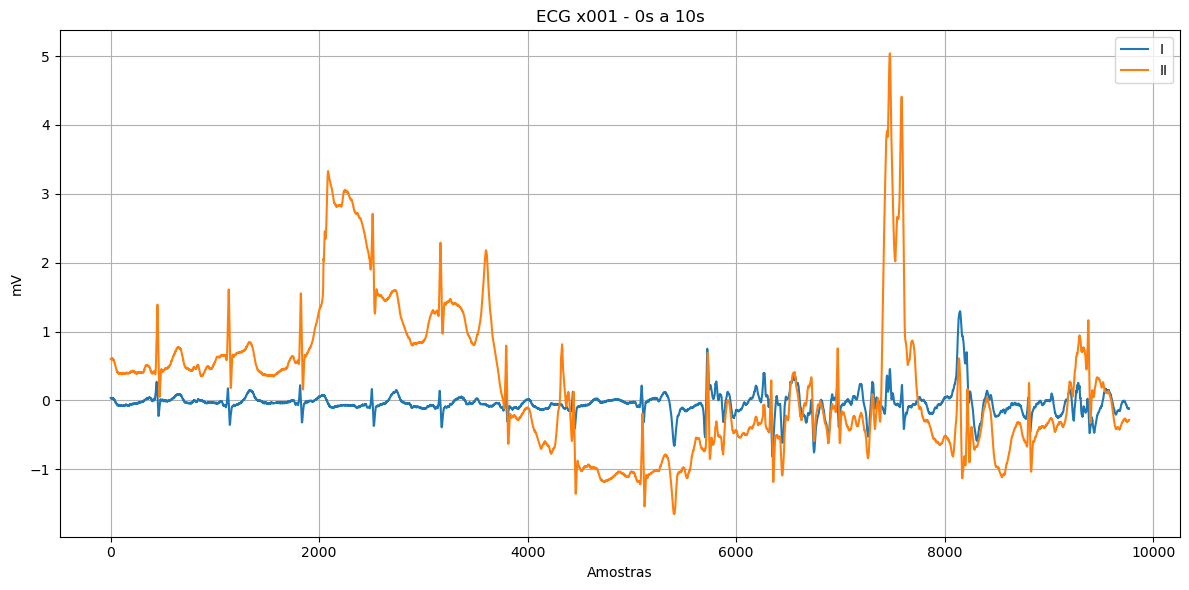

Primeiros 10 batimentos anotados:
Amostra: 194 | Tipo: ~ | Aux: 
Amostra: 93691 | Tipo: ~ | Aux: 
Amostra: 93981 | Tipo: + | Aux: (N
Amostra: 94109 | Tipo: N | Aux: 
Amostra: 94851 | Tipo: N | Aux: 
Amostra: 95579 | Tipo: N | Aux: 
Amostra: 96276 | Tipo: N | Aux: 
Amostra: 97013 | Tipo: N | Aux: 
Amostra: 97705 | Tipo: N | Aux: 
Amostra: 98364 | Tipo: N | Aux: 


In [1]:
import wfdb
import matplotlib.pyplot as plt
import os

# Caminho base dos arquivos .dat, .atr e .hea
base_path = 'db/'  # ex: 'C:/ECG/Leipzig'
record_name = 'x001'  # escolha um arquivo, por exemplo x001

# Caminho completo sem extensão
record_path = os.path.join(base_path, record_name)

# Lê o sinal e o cabeçalho
record = wfdb.rdrecord(record_path)
# Lê as anotações (batimentos)
annotation = wfdb.rdann(record_path, 'atr')

# Exibe informações básicas
print(f"Número de canais: {record.n_sig}")
print(f"Frequência de amostragem: {record.fs} Hz")
print(f"Duração: {len(record.p_signal) / record.fs:.2f} segundos")
print(f"Formatos dos sinais: {record.sig_name}")

# --- Visualização básica de um trecho (ex: primeiros 10 segundos)
fs = record.fs
start_time = 0
end_time = 10  # segundos
start_index = int(start_time * fs)
end_index = int(end_time * fs)

# Plotar os dois primeiros canais
plt.figure(figsize=(12, 6))
for i in range(min(2, record.n_sig)):
    plt.plot(record.p_signal[start_index:end_index, i], label=f'{record.sig_name[i]}')

plt.title(f'ECG {record_name} - {start_time}s a {end_time}s')
plt.xlabel('Amostras')
plt.ylabel('mV')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Visualizar anotações (batimentos)
print(f"Primeiros 10 batimentos anotados:")
for i in range(10):
    print(f"Amostra: {annotation.sample[i]} | Tipo: {annotation.symbol[i]} | Aux: {annotation.aux_note[i] if annotation.aux_note else 'N/A'}")


In [ ]:
# ECG Converter e Visualizador - Leipzig Style

import numpy as np
import matplotlib.pyplot as plt
import wfdb
from datetime import datetime
from scipy.signal import butter, filtfilt

# === CONFIGURAÇÕES ===
arquivo_entrada = 'ecg_bruto.txt'
arquivo_saida = 'meu_ecg_filtrado'
adc_bits = 12
v_ref = 3.3
fs = 977
ganho_adc = 10

# === FUNÇÕES ===
def filtro_passa_faixa(signal, fs, lowcut=0.5, highcut=45.0, ordem=8):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(ordem, [low, high], btype='band')
    return filtfilt(b, a, signal)

# === LEITURA SEGURA ===
valores_adc = []
with open(arquivo_entrada, 'r') as f:
    for linha in f:
        try:
            valor = int(linha.strip())
            if 0 <= valor <= 4095:
                valores_adc.append(valor)
        except ValueError:
            continue
valores_adc = np.array(valores_adc)
print(f"Amostras: {len(valores_adc)}")

# === CONVERSÃO PARA mV + CENTRALIZAÇÃO ===
valores_mv = (valores_adc / (2**adc_bits - 1)) * v_ref * 1000
valores_mv -= np.mean(valores_mv)
valores_mv = np.nan_to_num(valores_mv)
print(f"Faixa (mV): min = {np.min(valores_mv):.2f}, max = {np.max(valores_mv):.2f}")

# === FILTRO PASSA-FAIXA ===
valores_filtrados = filtro_passa_faixa(valores_mv, fs)
valores_filtrados = np.nan_to_num(valores_filtrados)

# === CONVERSÃO PARA WFDB ===
valores_np = valores_filtrados.reshape(-1, 1)
print("🔍 Faixa do sinal exportado em mV:")
print(f"Min: {np.min(valores_np):.2f}")
print(f"Max: {np.max(valores_np):.2f}")

wfdb.wrsamp(
    record_name=arquivo_saida,
    fs=fs,
    sig_name=['ECG'],
    units=['mV'],
    p_signal=valores_np,
    fmt=['16'],
    adc_gain=[ganho_adc],
    baseline=[0],
    comments=[f'Convertido com filtro passa-faixa e centralização, {datetime.now()}']
)
print(f"✅ Arquivos salvos: {arquivo_saida}.hea e {arquivo_saida}.dat")

# === PLOT DO TRAÇADO ===
tempo = np.linspace(0, len(valores_filtrados) / fs, len(valores_filtrados))
plt.figure(figsize=(12, 4))
plt.plot(tempo, valores_filtrados, label='ECG Filtrado')
plt.title("ECG filtrado e convertido para mV")
plt.xlabel("Tempo (s)")
plt.ylabel("mV")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()